In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import warnings
warnings.filterwarnings( 'ignore' )
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Personal - for code, not data.
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2

from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
font = {'tick': 12,
        'label': 14,
        'fig': 16}

## Perform alignment (or not)

The first timestamp in events before zero-ing is 1654735168087.340
The first timestamp in events after zero-ing is 0.000
143295 events recorded over 78 min and 57 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 1654709925.092
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 1654709925091.791
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1000.0
153210591 timestamps over 79 min and 47.8 s
Sampling rate is 32000 Hz
Detected 6082 syncs for 4732 sync pulse events
Loop 1: Inter-sync times failed to converge
Loop 8: Inter-sync times failed to converge
Loop 11: Inter-sync times failed to converge
Loop 12: Inter-sync times failed to converge
Loop 23: Inter-sync times failed to converge
Loop 24: Inter-sync times failed to converge
Loop 32: Inter-sync times failed to converge
Loop 40: Inter-sync times failed to converge
Loop 48: Inter-sync times failed to converge
Loop 61: Inter-sync t

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


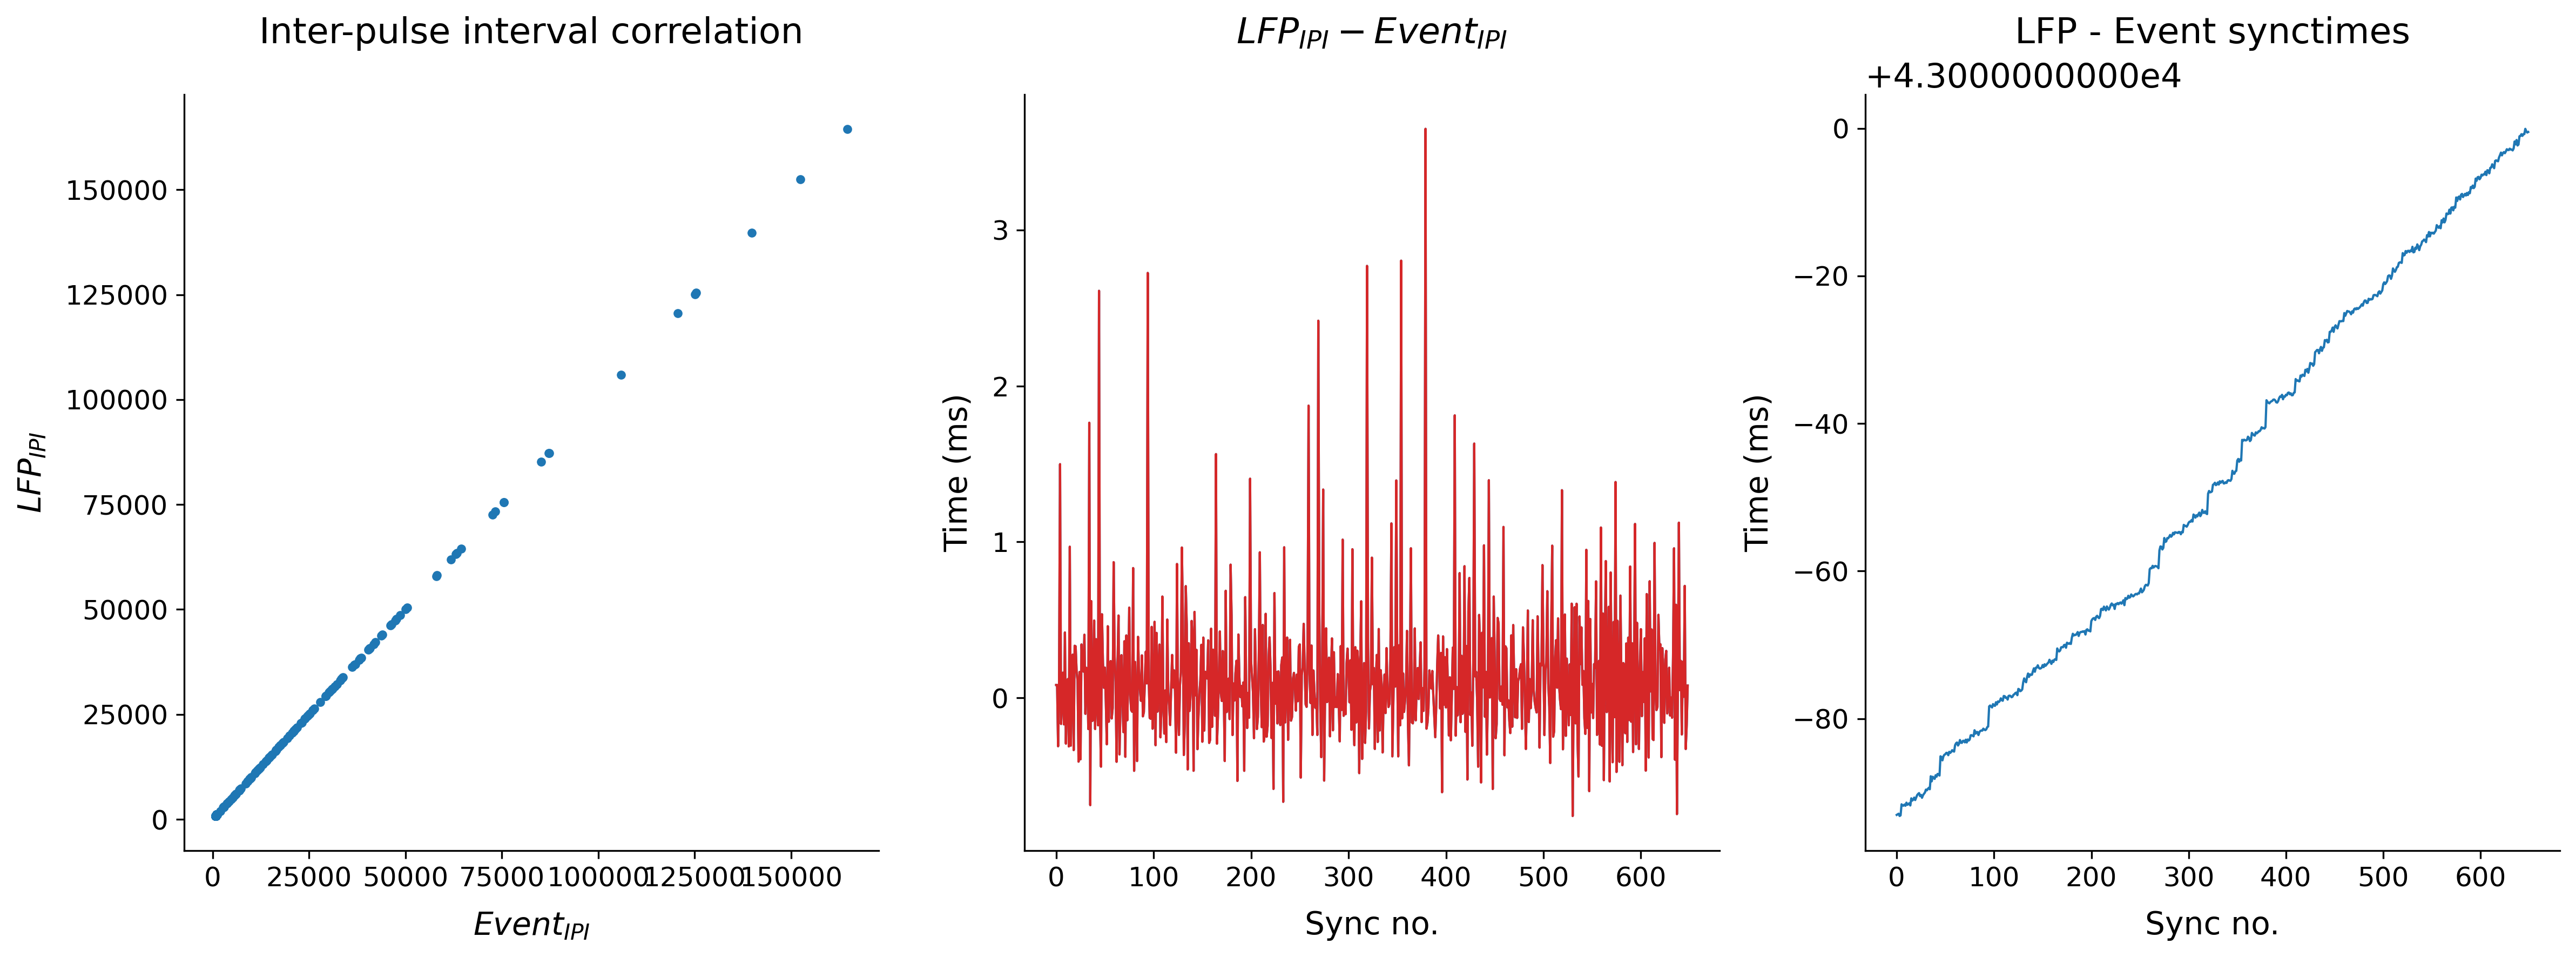

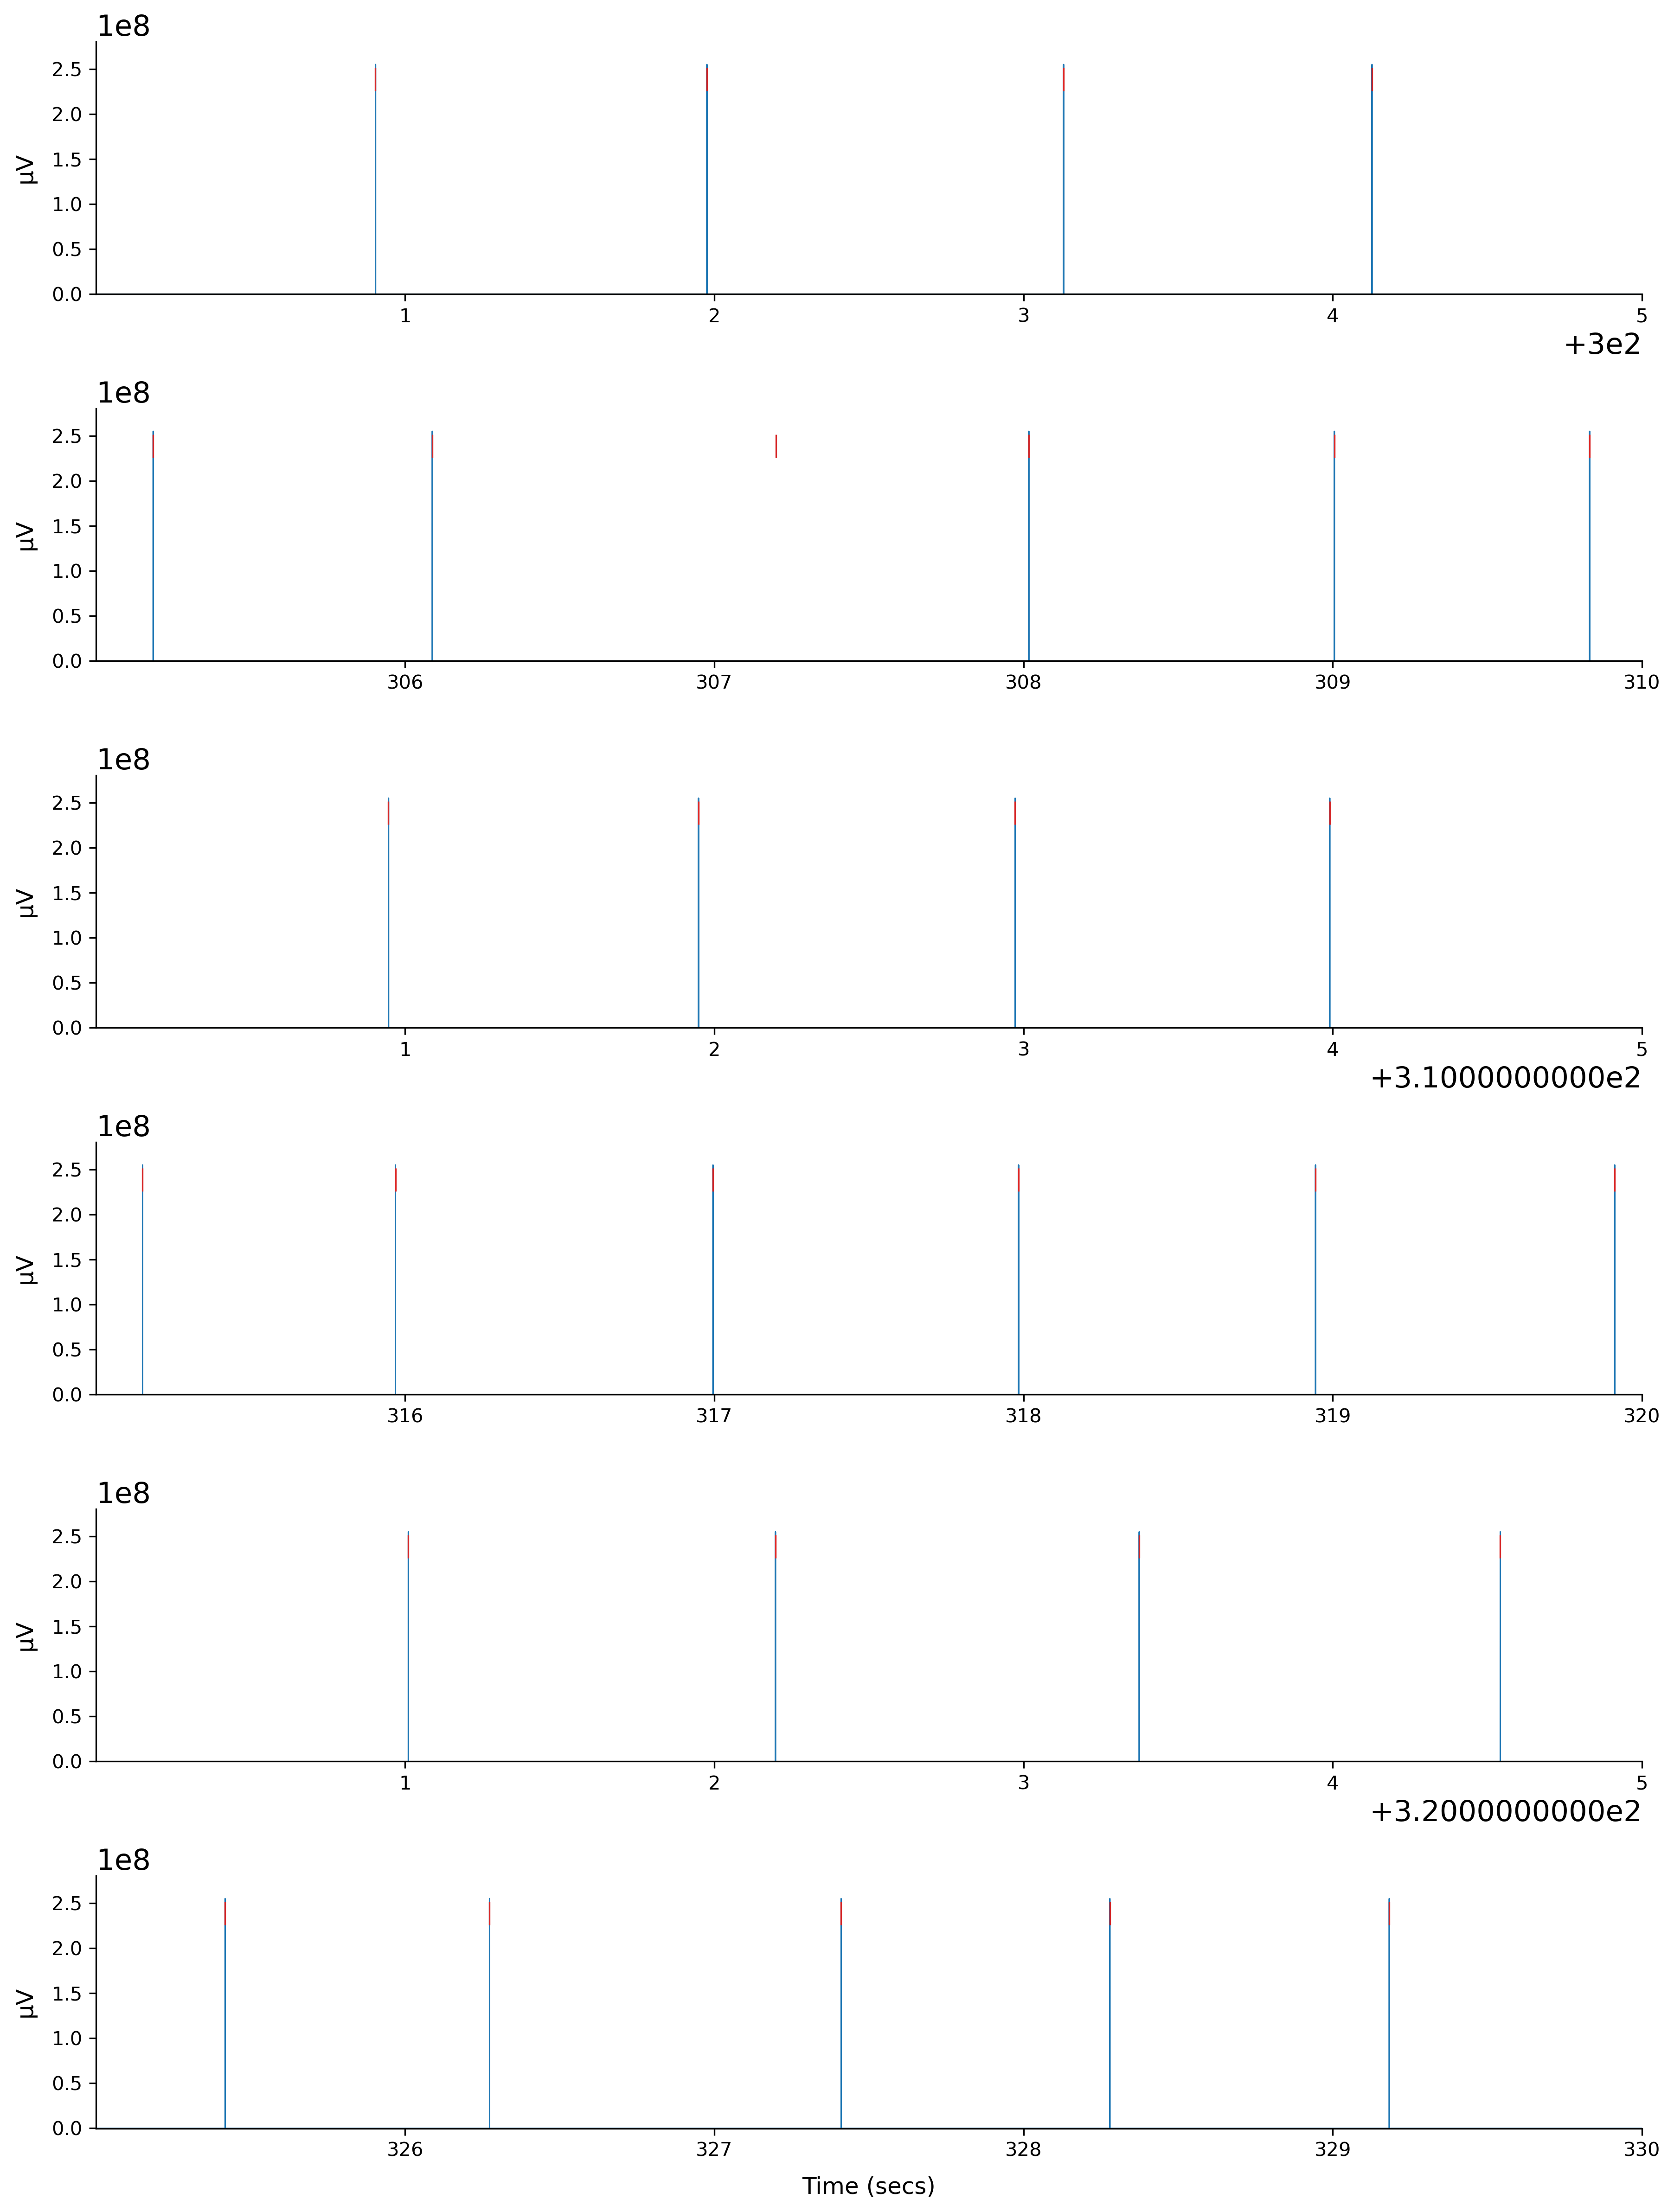

In [2]:
subj_sess = 'U554_ses0'

# Load the sync channel.
# sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')
sync_chan, TTL, timestamp_flag = events_preproc.load_syncs(subj_sess, data_key='data')

if not timestamp_flag: 
     
    # Read events file and get event synctimes.
    events, event_synctimes = events_preproc.read_events_json( subj_sess )

    # Load LFP timestamps.
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess )

    # Identify sync pulses in the sync channel EEG.
    pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
    
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')


    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, step=5, max_shift=200, max_slide=50, ipi_thresh=2)
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)
    
    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))    
    
    # How did our alignment go?
    print('{} event sync pulses'.format(len(event_synctimes_adj)))
    print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
    print('\n--------------------\nAlignment parameters\n--------------------')
    for k, v in alignment.items():
        print('{}: {}'.format(k, v))

    plt.close()
    fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
    ax = np.ravel(ax)

    min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
    start = 0
    stop = None

    i = 0
    ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
    ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

    i = 1
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

    i = 2
    ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
    fig.tight_layout()

    event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
    event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                  if x<len(lfp_timestamps)])).astype(np.int64)
    event_pulse_startinds_train = np.zeros(len(sync_chan))
    event_pulse_startinds_train[event_pulse_inds] = 1

    fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                          start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)  
else:    
    # Read events file and get event synctimes in msec.
    events, event_synctimes = events_preproc.read_events_json( subj_sess, start_at_zero = True  )
    
    # Load LFP timestamps in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess, start_at_zero = True, conv_factor = 'infer' )

    sync_chan_new = sync_chan
    sync_chan_new = sync_chan_new - sync_chan[0] 
    sync_chan_new *= 1000 ; # converts to msec
    TTL_new = TTL
    TTL_new[ np.where( TTL != 255) ] = 0
    from scipy import interpolate
    f = interpolate.interp1d(sync_chan_new, TTL_new, kind = 'next', fill_value='extrapolate')
    TTL_up = f( lfp_timestamps ) 
    
    plot_flag = 0
    if plot_flag:
        ind_range_1 = [ 0, 100000 ] 
        fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=300)
        plt.plot(lfp_timestamps[ slice( ind_range_1[0], ind_range_1[1], 1)], 
                 TTL_up[ slice( ind_range_1[0], ind_range_1[1], 1)],
                 marker = 'o', color = 'blue', linestyle = 'none', markersize = 8 )
    
    pulse_startinds = np.where( TTL_up == 255)[0] 
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    
    # 
    plot_flag = 0
    if plot_flag:
        time_range = [ 30000, 100000 ] 
        ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
        ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
        fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
        plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
                 np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
                 marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
        plt.plot(event_synctimes[ ind_event_synctimes ], 
                 np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
                 marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
        plt.show()        

    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')
    
    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, step=5, max_shift=200, max_slide=50, ipi_thresh=2)
    
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)

    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x)) 
    print( events[21:40:1] )

    # How did our alignment go?
    print('{} event sync pulses'.format(len(event_synctimes_adj)))
    print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
    print('\n--------------------\nAlignment parameters\n--------------------')
    for k, v in alignment.items():
        print('{}: {}'.format(k, v))

    plt.close()
    fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
    ax = np.ravel(ax)

    min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
    start = 0
    stop = None

    i = 0
    ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
    ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

    i = 1
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

    i = 2
    ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
    fig.tight_layout()    

    event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
    event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                  if x<len(lfp_timestamps)])).astype(np.int64)
    event_pulse_startinds_train = np.zeros(len(lfp_timestamps))
    event_pulse_startinds_train[event_pulse_inds] = 1

    fig, ax = plot_trace2(TTL_up, spike_dat=event_pulse_startinds_train,
                          start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)
    
    
    plot_flag = 0 
    # Creating histogram
    if plot_flag:
        fig, ax = plt.subplots(figsize =(10, 7))
        ax.hist(np.diff( events['time'] ), bins = range(0,1000,25) )

## Format events and spikes

In [3]:
proc_events = 1
proc_spikes = 1
proj_dir = '/home1/cjmac/projects/time_cells'
run_all = True
save_output = True
overwrite = False
verbose = True

start_time = time()
warnings.filterwarnings('ignore')

if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)

Processing events data.

Incomplete trials:
trial  gameState  
0      DoNextTrial    2.720660e+06
       InitTrial      0.000000e+00
Name: time, dtype: float64
Removing incomplete trials...
Noisy trials:
Series([], Name: time, dtype: float64)
Paused trials:
Series([], Name: time, dtype: float64)
Main experiment has 137868 events recorded over 67 min and 21 sec
Saved /home1/cjmac/projects/time_cells/analysis/events/U554_ses0-events_formatted.pkl


In [ ]:
# from importlib import reload

# reload( events_proc )
print(events['key'].value_counts())

In [ ]:
if True:
    events = events_proc.load_events(subj_sess,
                                     proj_dir=proj_dir,
                                     overwrite=overwrite,
                                     verbose=verbose,
                                     run_all=run_all)

    if save_output:
        events_proc.save_events(events,
                                overwrite=overwrite,
                                verbose=verbose)

if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

warnings.resetwarnings()
print('Done in {:.2f} s'.format(time() - start_time))

savefile = True
overwrite = False

# event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
# if savefile:
#     time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

In [ ]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/cjmac/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=False,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/cjmac/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/cjmac/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        #output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
print('{} neurons'.format(len(subj_sess_neurons)))

In [ ]:
# subj_sess_neurons = [ subj_sess_neurons[1] ]
# type( subj_sess_neurons )

In [ ]:
#  subj_sess_neurons = [ subj_sess_neurons[1] ] #cjm
# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

In [ ]:
import pickle

with open('U540_ses0-4-1-ols-time_bin-model_pairs.pkl', 'rb') as f:
    data = pickle.load(f)


In [ ]:
%cd /home1/cjmac/projects/time_cells/analysis/unit_to_behav
